## With reduction to 4 parameters, two of which are integers, we can very easily visualize / minimize this space

In [1]:
import numpy as np
from utils import efficiency_calc, validate_parameters, score_vals
import math
import os
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4" # select number of desired GPU to be used
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [3]:
# Parameters:
int_bounds = {
    "z_sh": [6, 12], #NOTE - z_sh is actually half z_s (which must be even)
    "z_r2": [70, 85], # limit so that ring 2 is always smaller than ring 1
    "C_10": [0, 3], # can consider these integers (e-4 gives in m). Note we're staying under the 0.4 theoretical limit.
    "p1_off": [-1, 2],
    "p2_off": [-1, 2]
}

float_bounds = {
    "x_s": [-0.8, 0.8],
    "x_r2": [-1., 1.],
}

In [4]:
# Total number of integer pairs within give range:
math.prod((subsets[1]-subsets[0]+1) for subsets in int_bounds.values())

7168

In [5]:
# visualization & scoring function
'''
inputs: x_bounds - dict of x_s and x_r2 bounds
            ints - [3,] chosen z_sh, z_r2, and C_10 values
outputs: eff_score - efficiency/gear ratio score calculated from efficiency_calc function (plotted)
'''
def x_to_eff_score(x_bounds, ints, show_plot=False, resolution = 0.025, mu = 0.21):
    z_sh, z_r2, c_10, p1_offset, p2_offset = ints
    Cl = c_10 * 1e-4 # convert to m
    x_s = np.arange(x_bounds["x_s"][0], x_bounds["x_s"][1], resolution)
    x_r2 = np.arange(x_bounds["x_r2"][0], x_bounds["x_r2"][1], resolution)
   
    #in-vals in form [z_sh, z_r2, xs, xr2, Cl]
    in_vals = [[z_sh], [z_r2], x_s, x_r2, [Cl]]
    _, design_vals, eta_bwd, ratios = score_vals(in_vals, offsets=[p1_offset, p2_offset], add_gear= False, return_verbose=True, mu=mu)
    _, z_p1, z_p2, _, xs, xp1, xp2, xr2, r_a = design_vals
    
    score = eta_bwd * ratios
    # print(f'Shapes: eta_bwd: {eta_bwd.shape}, ratios: {ratios.shape}, score: {score.shape}')
    if show_plot:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('x_s')
        ax.set_ylabel('x_r2')
        ax.set_zlabel('Efficiency Score')

        ax.scatter(xs, xr2, score, c=score, cmap='viridis', marker='o', s=0.1)
        plt.title(f"Efficiency Score for z_sh: {z_sh}, z_r2: {z_r2}, C_10: {c_10}")
        bar = plt.colorbar(ax.collections[0])
        bar.set_label('Efficiency Score')
        plt.show()
    return score

In [6]:
x_to_eff_score(float_bounds, [6, 70, 1, 0, 0])

array([17.26025106, 17.23750695, 17.19365793, ..., 20.22109274,
       20.21925378, 20.21328922])

# TODO - may be best to view pareto front for efficiency & gear ratio for each z

In [7]:
# # Note on friction values:
# PLA calculated friction values are as follows (static, kinetic):
# PLA_LI_Grease_Thin: 0.14, 0.09
# PLA_NonLubricated: 0.18, 0.08
# PLA_MineralOil: 0.21, 0.11
# PLA_PTFE: 0.36, 0.11
# PLA_Si_Grease_Thin: 0.52, 0.39
# PLA_LI_Grease: 0.75, 0.35

In [8]:
# TASK: We want to design a gearbox with the largest gear ratio and the lowest required backdrive torque.
# To approximate this, we will score based on the product of the gear ratio and the backdrive efficiency.
# NOTE - we will use a fixed friction value based on preliminary testing, but this will change with other design parameters.
# The goal is to find the combination of z_sh, z_r2, and clearance that will enable the best score.
# Then we can choosen x values that work within those other parameter bounds.

#Pseudo-Code:

# 1. Iterate through all combinations of integer values (z_s, z_r2, and clearence) within the given range & solve 
# 2. For all values within the range of x_s and x_r2, calculate the efficiency score and take the max (best case)
# 3. View max scores as a function of z_s and z_r2 (3D plot with clearance as well) - choose vals that can maximize score
# 4. 

c:\Users\Greg\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Greg\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Greg\Python\Git_Local\Mod_DOE\utils.py:94: RuntimeWarning: divide by zero encountered in divide
  ratios = 1 / gr_s
c:\Users\Greg\Python\Git_Local\Mod_DOE\utils.py:183: RuntimeWarning: divide by zero encountered in divide
  return (1 + I1)*Ea_val*(1-Eb_val*Ec_val*I2)/((Ea_val+Eb_val*I1)*(1-I2))
c:\Users\Greg\Python\Git_Local\Mod_DOE\utils.py:181: RuntimeWarning: divide by zero encountered in divide
  return (1 + I1) * Ea_val * (Eb_val * Ec_val - I2) / (Ec_val * (Ea_val * Eb_val + I1) * (1 - I2))
C:\Users\Greg\AppData\Local\Temp\ipykernel_16352\3923332389.py:18: RuntimeWarning: invalid value encou

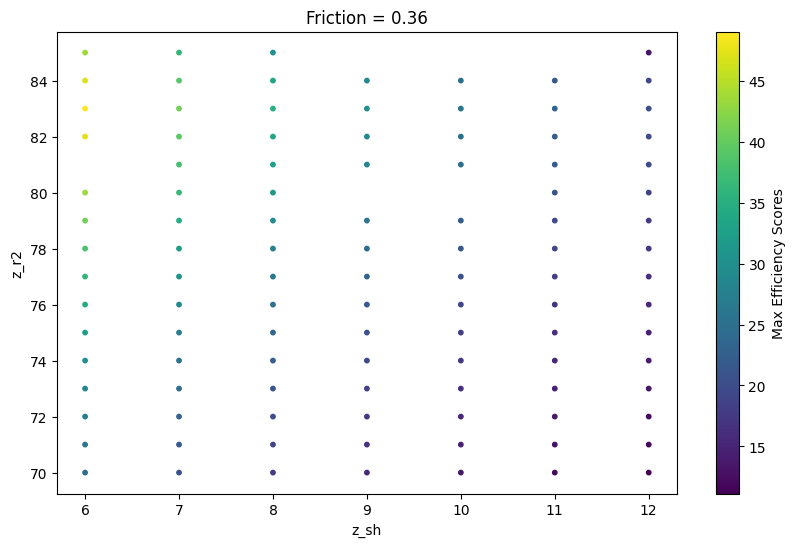

Best z_sh values: [6. 7. 8. 9.]
Best z_r2 values: [83. 85. 82. 84.]


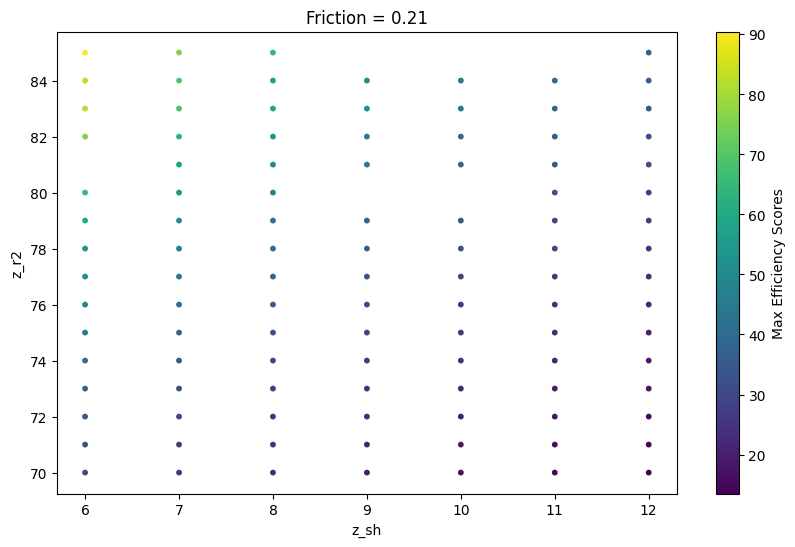

Best z_sh values: [6. 7. 8. 9.]
Best z_r2 values: [85. 83. 84. 82.]


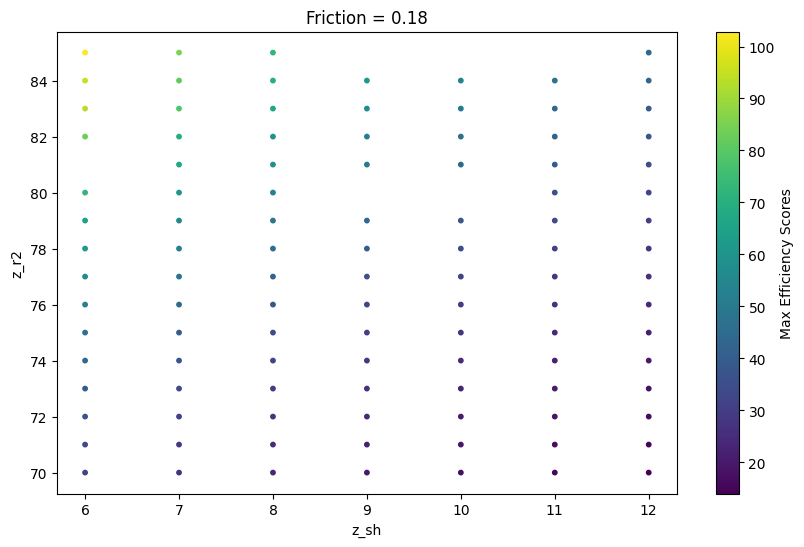

Best z_sh values: [6. 7. 8. 9.]
Best z_r2 values: [85. 84. 83. 82.]


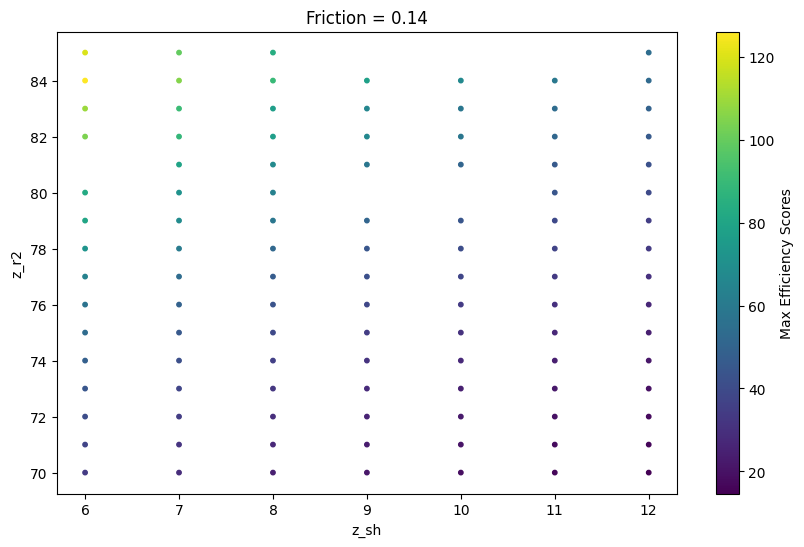

Best z_sh values: [6. 7. 8. 9.]
Best z_r2 values: [85. 84. 83. 82.]


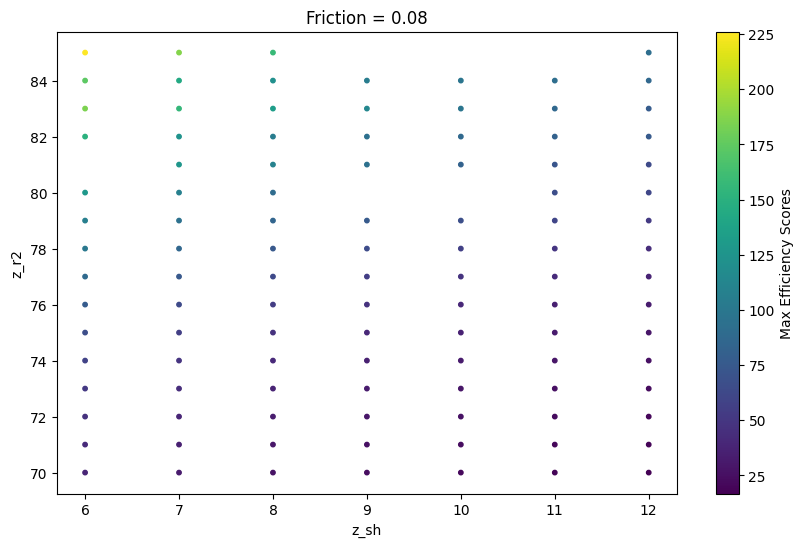

Best z_sh values: [6. 7. 8. 9.]
Best z_r2 values: [85. 83. 84. 82.]


In [9]:
for in_mu in [0.36, 0.21, 0.18, 0.14, 0.08]: # try different friction values

    z_sh_range = np.arange(int_bounds["z_sh"][0], int_bounds["z_sh"][1]+1, 1)
    z_r2_range = np.arange(int_bounds["z_r2"][0], int_bounds["z_r2"][1]+1, 1)
    C_10_range = np.arange(int_bounds["C_10"][0], int_bounds["C_10"][1]+1, 1)
    max_scores = np.zeros((len(z_sh_range), len(z_r2_range)))
    z_sh_flat = []
    z_r2_flat = []
    C_10_flat = []
    max_scores_flat = []
    for z_sh in z_sh_range: 
        for z_r2 in z_r2_range:
            max_score = 0
            for c_10 in C_10_range:
                for p1_offset in int_bounds["p1_off"]:
                    for p2_offset in int_bounds["p2_off"]:
                        # Calculate the efficiency score for the given parameters
                        score = x_to_eff_score(float_bounds, [z_sh, z_r2, c_10, p1_offset, p2_offset], show_plot=False, resolution=0.01, mu = in_mu)
                        if score.max() > max_score:
                            max_score = score.max()
            max_scores[z_sh - int_bounds["z_sh"][0], z_r2 - int_bounds["z_r2"][0]] = max_score
            z_sh_flat.append(z_sh)
            z_r2_flat.append(z_r2)
            max_scores_flat.append(score.max())

    # Convert to numpy arrays for easier manipulation
    z_sh_flat = np.array(z_sh_flat)
    z_r2_flat = np.array(z_r2_flat)
    max_scores_flat = np.array(max_scores_flat)

    # look at top-down plane (only for best cl (cl_10 = 1)):
    top_indices = np.where(C_10_flat == 1)
    top_z_sh_flat = z_sh_flat[top_indices]
    top_z_r2_flat = z_r2_flat[top_indices]
    top_scores = max_scores_flat[top_indices]
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.scatter(z_sh_flat, z_r2_flat, c=max_scores_flat, cmap='viridis', marker='o', s=10)
    ax.set_xlabel('z_sh')
    ax.set_ylabel('z_r2')
    ax.set_title('Friction = ' + str(in_mu))
    bar = plt.colorbar(ax.collections[0])
    bar.set_label('Max Efficiency Scores')
    plt.show()

    # report the 4 best values summing over z_sh and z_r2:
    best_zsh = np.zeros(4,)
    best_zsh_scores = np.zeros(4,)
    best_zr2 = np.zeros(4,)
    best_zr2_scores = np.zeros(4,)

    for z_sh in z_sh_range:
        inds = np.where(z_sh_flat == z_sh)
        score = max_scores_flat[inds]
        if np.nanmean(score) > np.min(best_zsh_scores):
            min_ind = np.argmin(best_zsh_scores)
            best_zsh[min_ind] = z_sh
            best_zsh_scores[min_ind] = np.nanmean(score)
    # sort best_zsh by best_zsh_scores
    sorted_indices = np.argsort(best_zsh_scores)[::-1]
    best_zsh = best_zsh[sorted_indices]
    
    for z_r2 in z_r2_range:
        inds = np.where(z_r2_flat == z_r2)
        score = max_scores_flat[inds]
        if np.nanmean(score) > np.min(best_zr2_scores):
            min_ind = np.argmin(best_zr2_scores)
            best_zr2[min_ind] = z_r2
            best_zr2_scores[min_ind] = np.nanmean(score)
    # sort best_zr2 by best_zr2_scores
    sorted_indices = np.argsort(best_zr2_scores)[::-1]
    best_zr2 = best_zr2[sorted_indices]
    print(f'Best z_sh values: {best_zsh}')
    print(f'Best z_r2 values: {best_zr2}')





From above, it is clear that we want as low a z_sh and clearance as we can get.
Regarding z_r2, it looks like a lower the z_r2 is more conservative. Meaning it will perform better for higher friction values. A higher z_r2 is more aggressive, meaning the best possible performance is better.

In [10]:
# looking at above plots - let's choose:
chosen_z_sh = np.array([6, 7, 8, 9]) # lowest values we can manufacture reliably
# chosen_z_r2 = np.array([76, 78, 81, 83]) # Range from optimistic to resilient (in terms of friction) - NO OFFSETS
chosen_z_r2 = np.array([76, 81, 83, 85]) # Include no-offset values, but move towards optimistic range
# chosen_cl_10 = np.array([0, 1.3e-4, 2.6e-4, 4e-4])
chosen_cl_10 = np.array([1e-4, 2e-4, 3e-4, 4e-4]) # Range from optimistic to resilient (in terms of friction)

C:\Users\Greg\AppData\Local\Temp\ipykernel_16352\457777931.py:20: RuntimeWarning: invalid value encountered in multiply
  top_scores.append(np.nanmax(eta_bwd * ratios))


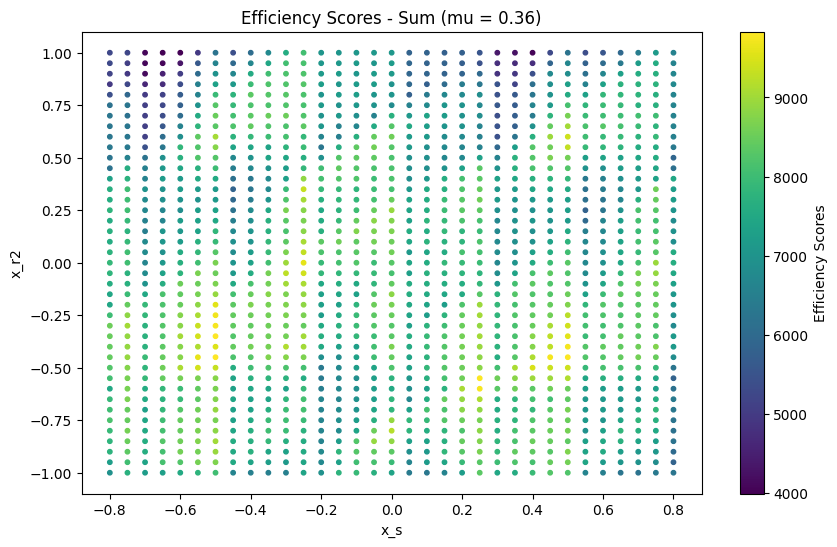

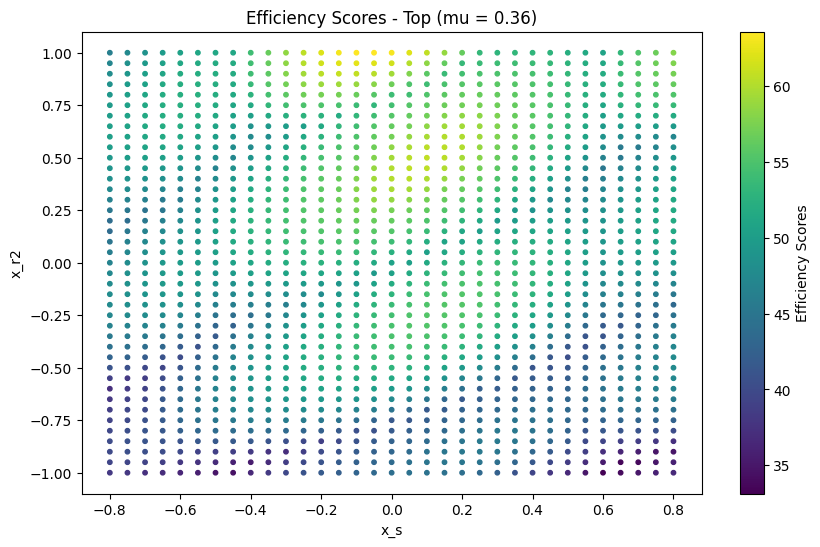

Best xs values: [ 5.00000000e-02  6.66133815e-16  1.00000000e-01 -5.00000000e-02]
Best xr2 values: [1.   0.95 0.9  0.85]
Best xs values: [-5.00000000e-01 -2.50000000e-01  5.00000000e-01  6.66133815e-16]
Best xr2 values: [-0.4  -0.35 -0.45 -0.3 ]


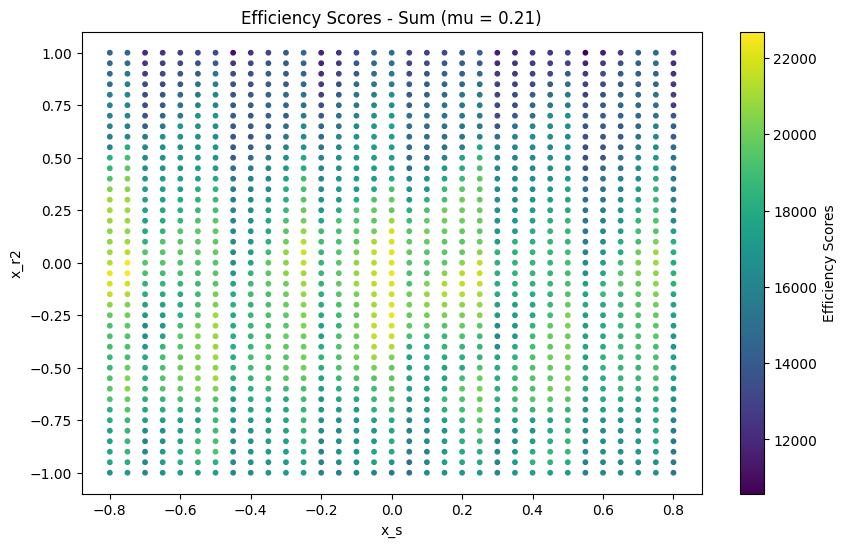

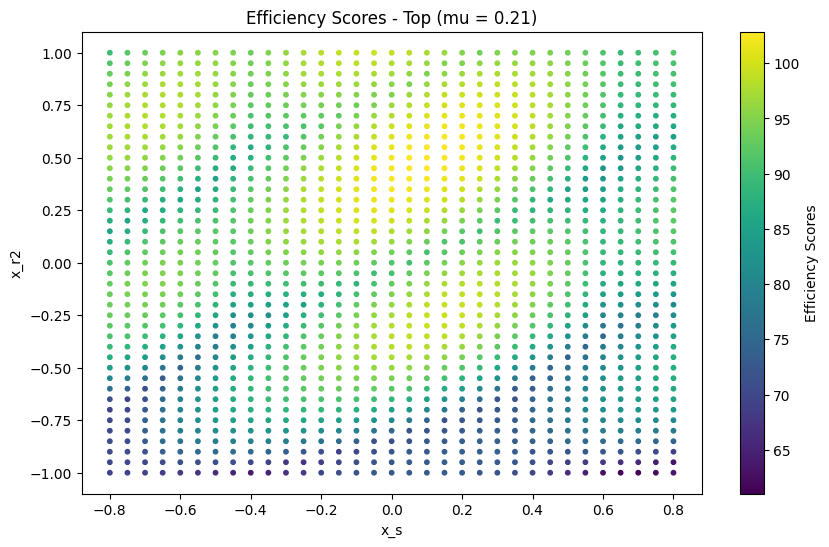

Best xs values: [ 6.66133815e-16  5.00000000e-02  1.00000000e-01 -5.00000000e-02]
Best xr2 values: [0.8  0.75 0.85 0.7 ]
Best xs values: [ 6.66133815e-16 -7.50000000e-01  2.50000000e-01 -5.00000000e-02]
Best xr2 values: [-5.0000000e-02 -1.0000000e-01  8.8817842e-16 -1.5000000e-01]


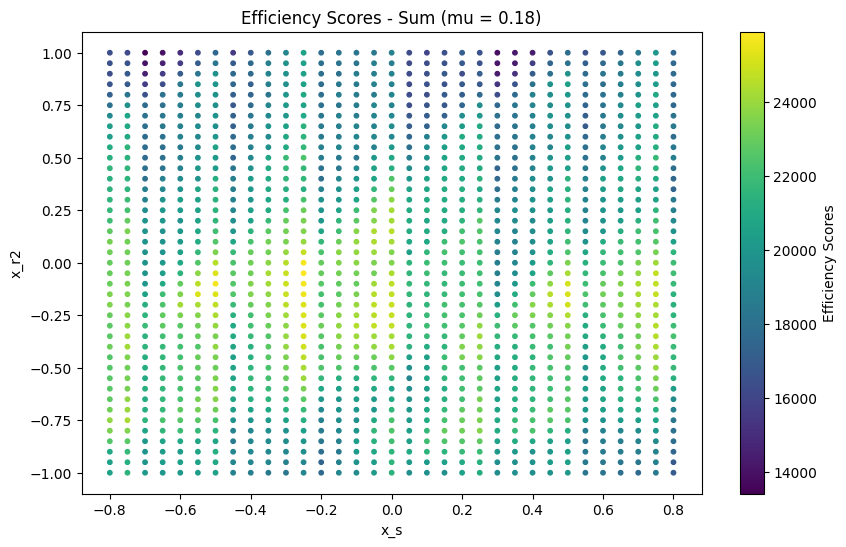

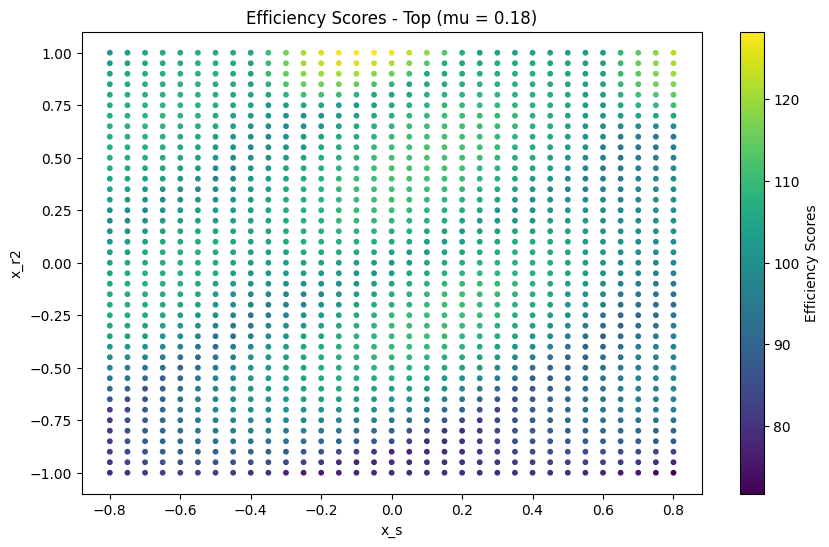

Best xs values: [-5.00000000e-02 -1.00000000e-01  6.66133815e-16 -1.50000000e-01]
Best xr2 values: [1.   0.95 0.9  0.85]
Best xs values: [-2.50000000e-01  6.66133815e-16 -7.50000000e-01 -5.00000000e-01]
Best xr2 values: [-0.2  -0.15 -0.25 -0.3 ]


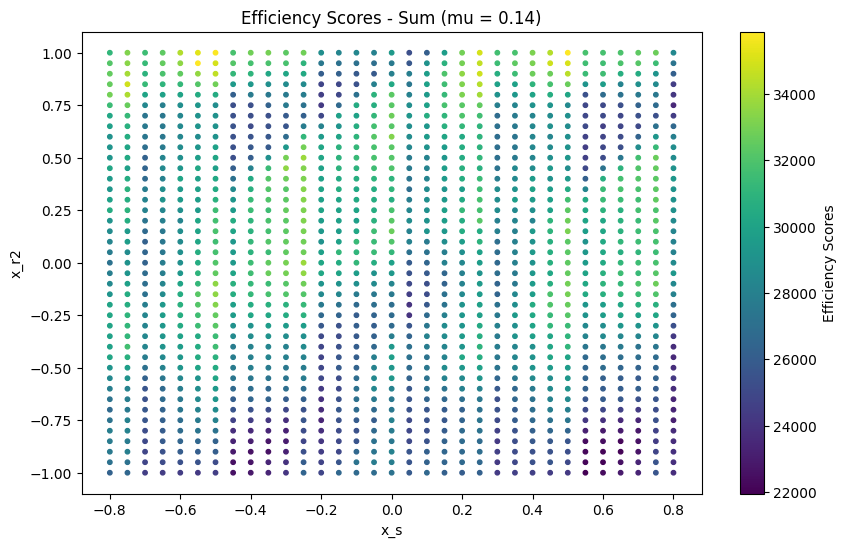

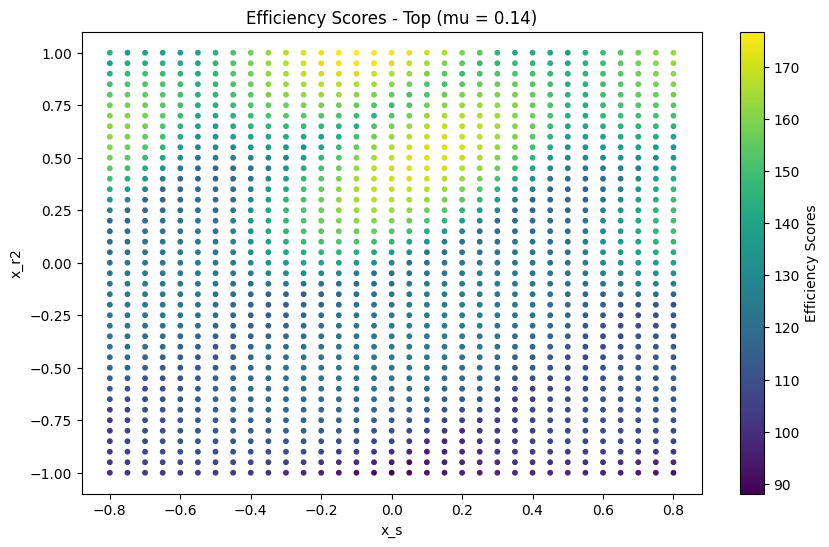

Best xs values: [-5.00000000e-02 -1.00000000e-01  6.66133815e-16  5.00000000e-02]
Best xr2 values: [0.9  1.   0.85 0.95]
Best xs values: [-0.5   0.25  0.5  -0.75]
Best xr2 values: [1.   0.95 0.9  0.3 ]


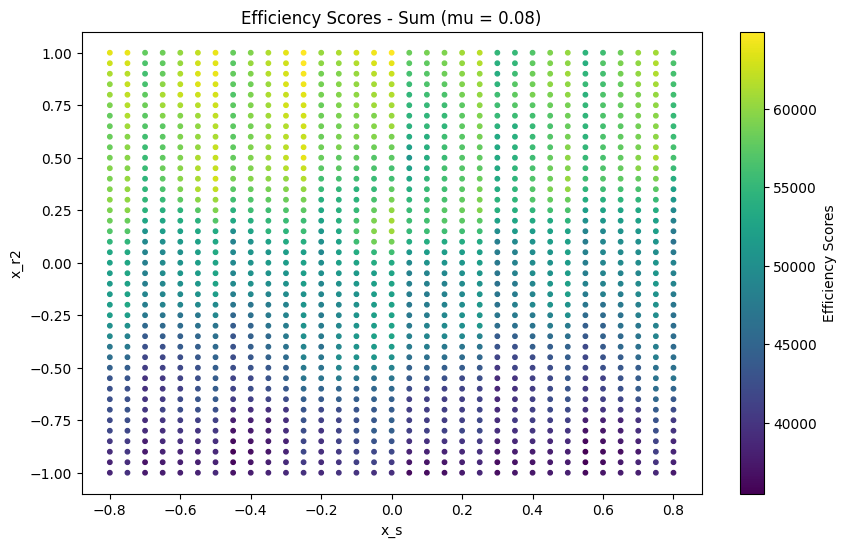

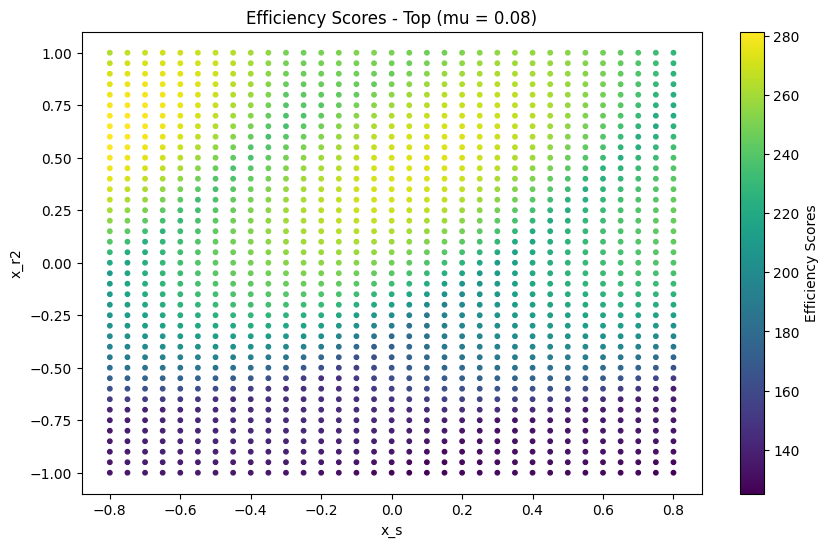

Best xs values: [-0.7  -0.75 -0.65 -0.8 ]
Best xr2 values: [0.65 0.7  0.6  0.75]
Best xs values: [ 6.66133815e-16 -2.50000000e-01 -5.00000000e-02 -7.50000000e-01]
Best xr2 values: [1.   0.95 0.9  0.85]


In [13]:
for in_mu in [0.36, 0.21, 0.18, 0.14, 0.08]:
    # find the x calues that perform best across each of these ranges.
    resolution = 0.05
    test_xs = np.arange(float_bounds["x_s"][0], float_bounds["x_s"][1] + resolution, resolution)
    test_xr2 = np.arange(float_bounds["x_r2"][0], float_bounds["x_r2"][1]+ resolution, resolution)

    # find the efficiency scores for each of these combinations:
    x_s = []
    x_r2 = []
    eff_scores = []
    top_scores = []
    for ind1, xs in enumerate(test_xs):
        for ind2, xr2 in enumerate(test_xr2):
            in_vals = [chosen_z_sh, chosen_z_r2, np.array([xs]), np.array([xr2]), chosen_cl_10]
            offsets = np.array([[-1, 0, 1, 2],[-1, 0, 1, 2]])
            gr_score, validated_design_vals, eta_bwd, ratios = score_vals(in_vals, offsets=offsets, add_gear=False, return_verbose=True, mu=in_mu)
            x_s.append(xs)
            x_r2.append(xr2)
            eff_scores.append(gr_score)
            top_scores.append(np.nanmax(eta_bwd * ratios))



    # Convert to numpy arrays for easier manipulation
    x_s = np.array(x_s)
    x_r2 = np.array(x_r2)
    eff_scores = np.array(eff_scores)
    top_scores = np.array(top_scores)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_xlabel('x_s')
    ax.set_ylabel('x_r2')
    ax.set_title('Efficiency Scores - Sum (mu = ' + str(in_mu) + ')')
    ax.scatter(x_s, x_r2, c=eff_scores, cmap='viridis', marker='o', s=10)
    bar = plt.colorbar(ax.collections[0])
    bar.set_label('Efficiency Scores')
    plt.show()

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.set_xlabel('x_s')
    ax.set_ylabel('x_r2')
    ax.set_title('Efficiency Scores - Top (mu = ' + str(in_mu) + ')')
    ax.scatter(x_s, x_r2, c=top_scores, cmap='viridis', marker='o', s=10)
    bar = plt.colorbar(ax.collections[0])
    bar.set_label('Efficiency Scores')
    plt.show()


    best_xs_scores = np.zeros(4,)
    best_xs = np.zeros(4,)
    best_xr2_scores = np.zeros(4,)
    best_xr2 = np.zeros(4,)

    best_mean_xs_scores = np.zeros(4,)
    best_mean_xs = np.zeros(4,)
    best_mean_xr2_scores = np.zeros(4,)
    best_mean_xr2 = np.zeros(4,)


    for xs in test_xs:
        inds = np.where(x_s == xs)
        score = top_scores[inds]
        if np.nanmean(score) > np.min(best_xs_scores):
            min_ind = np.argmin(best_xs_scores)
            best_xs[min_ind] = xs
            best_xs_scores[min_ind] = np.nanmean(score)
    # sort best_zsh by best_zsh_scores
    sorted_indices = np.argsort(best_xs_scores)[::-1]
    best_xs = best_xs[sorted_indices]
    
    for xr2 in test_xr2:
        inds = np.where(x_r2 == xr2)
        score = top_scores[inds]
        if np.nanmean(score) > np.min(best_xr2_scores):
            min_ind = np.argmin(best_xr2_scores)
            best_xr2[min_ind] = xr2
            best_xr2_scores[min_ind] = np.nanmean(score)
    # sort best_xr2 by best_xr2_scores
    sorted_indices = np.argsort(best_xr2_scores)[::-1]
    best_xr2 = best_xr2[sorted_indices]
    print(f'Best xs values: {best_xs}')
    print(f'Best xr2 values: {best_xr2}')

    for xs in test_xs:
        inds = np.where(x_s == xs)
        score = eff_scores[inds]
        if np.nanmean(score) > np.min(best_mean_xs_scores):
            min_ind = np.argmin(best_mean_xs_scores)
            best_mean_xs[min_ind] = xs
            best_mean_xs_scores[min_ind] = np.nanmean(score)
    # sort best_zsh by best_zsh_scores
    sorted_indices = np.argsort(best_mean_xs_scores)[::-1]
    best_mean_xs = best_mean_xs[sorted_indices]
    
    for xr2 in test_xr2:
        inds = np.where(x_r2 == xr2)
        score = eff_scores[inds]
        if np.nanmean(score) > np.min(best_mean_xr2_scores):
            min_ind = np.argmin(best_mean_xr2_scores)
            best_mean_xr2[min_ind] = xr2
            best_mean_xr2_scores[min_ind] = np.nanmean(score)
    # sort best_xr2 by best_xr2_scores
    sorted_indices = np.argsort(best_mean_xr2_scores)[::-1]
    best_mean_xr2 = best_mean_xr2[sorted_indices]
    print(f'Best xs values: {best_mean_xs}')
    print(f'Best xr2 values: {best_mean_xr2}')


Looking at above - there seems to be some magic at x_s = -0.25 and x_s = 0.75 for top scores. 
-0.5 and +0.5 seem to be on the conservative end for higher frictions.
High xr2 seem to do well for max scores: should include optimistic values of 0.85 and 1.0 . -0.45 seems pretty conservative, I'd add 0 as well.

NOTE - there are drop-offs in efficiencies for values very close to these scores. it's possible that our manufacturing imprecision could be an issue if we shoot for exact.

In [ ]:
# Pre-offset chosen values:
x_s_chosen = np.array([-0.5, -0.25, 0.5, 0.75])
x_r2_chosen = np.array([-0.45, 0, 0.85, 1.0])

In [14]:
# With offsets included:
x_s_chonse = np.array([-0.8, -0.5, 0, 0.5])
x_r2_chosen = np.array([-0.25, 0, 0.5, 1]) # next in would be 0.75
